In [1]:
### TODO:
#   - !!najdi primerni podatkovni bazi za regresijo in klasifikacijo
#   - omogoči naključno rezanje uteži
#   - !!ustvari lažje podajanje hiperparametrov
#   - !!ročno inicializiraj uteži z Gaussian Glorot initialization ALI Gaussian z standard deviation 0.1
#   - !!ustvari lepši ui, ki na boljši način prikaže rezanje in učenje.
#   - podatke kot je early stopping rate, natančnost itd. itd. je treba nekje shraniti in prikazati
#   - !!sproti shranjuj nekatere modele npr. najbolj natančnega, najbolj rezanega ali po vsakem rezanjuž
#   - !!dodaj dve opciji globalno prunanje ali prunanje po sloju
#   - !!izboljšaj early stoppage tako da si shraniš model kot je val večji in ga nato loadaš v primeru če se je učenje prenehalo zaradi early stoppage
#   - v statistiko še dodaj druge metrike kot precision recall in F1
#   - dodaj možnost kjer prunaš samo nekatere uteži npr. samo convolution layerje
#   - !!popravi napako, kjer se zadnja epoha ne pokaže pre early stoppage
#   - Ko šteješ koliko ničel in neničel je štej rajši z maske

### TODO:
#   - probaj densenet brez pretrained uteži
#   - probaj preprečiti rezanje batch norm plasti v densenet
#   - poglej kaki bodo rezultati če znižaš resolucijo slik
#   - probaj znižati learning rate na 1e-5
#   - probaj ročno spremeniti število izhodov za zadnji layer

## NEKAJ JE NAROBE PRI ALEXNET NORMAL WEIGHTS

#POMEMBNO: Za errror pri squeezenet1_1 je kriva glorotova inicializacija uteži

In [1]:
import torch
import numpy as np
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchinfo
import matplotlib
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

from neural_network import *
from dataset_realwaste import *
from dataset_chest_xray import *
from iterative_pruning import IterativePruning

#from torchvision.models import squeezenet1_1
from torchvision.models import densenet121
from torchvision.models import resnet18
from torchvision.models import alexnet
from torchvision.models import vgg11
#from torchvision.models import efficientnet_v2_s
from torchvision.models import shufflenet_v2_x1_0

from test import Conv6

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
NUM_CHANNELS = 1
BATCH_SIZE = 32
NUM_EPOCHS = 100
NUM_PRUNE_ITER = 10
PRUNE_PER = 0.3
IMAGE_SIZE = [256,256] #[256,256] #[524, 524]  #[28, 28]
LR = 3e-4 #1e-4 #1.2e-3

In [4]:
## MNIST

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x.expand(3, -1, -1)),
])

##pin_memory in num_workers=6

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_subset, val_subset = torch.utils.data.random_split(mnist_trainset, [50000, 10000], generator=torch.Generator().manual_seed(1))

train_loader = DataLoader(dataset=train_subset, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_subset, shuffle=False, batch_size=BATCH_SIZE)

mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(mnist_testset, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
## REALWASTE

inputs, targets, label_encoder = getRealWasteDataset()

train_size = int(0.7 * len(inputs))
val_size = int(0.15 * len(inputs))
test_size = len(inputs) - train_size - val_size

train_dataset = RealWasteDataset(inputs[:train_size,:], targets[:train_size], IMAGE_SIZE, True)
val_dataset = RealWasteDataset(inputs[train_size : train_size + val_size,:], targets[train_size : train_size + val_size], IMAGE_SIZE, False)
test_dataset = RealWasteDataset(inputs[-test_size:,:], targets[-test_size:], IMAGE_SIZE, False)

#train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(real_waste_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(1))

#for input, target in train_dataset.dataset:
#    train_dataset.dataset += [(torchvision.transforms.functional.hflip(input), target)]
#    train_dataset.dataset += [(torchvision.transforms.functional.rotate(input, -90), target)]

train_loader = DataLoader(dataset = train_dataset, shuffle = True, batch_size = BATCH_SIZE)
val_loader = DataLoader(dataset = val_dataset, shuffle = False, batch_size = BATCH_SIZE)
test_loader = DataLoader(dataset = test_dataset, shuffle = False, batch_size = BATCH_SIZE)


In [7]:
## CHEST XRAY
chest_xray_dataset = ChestXRayDataset("./data/kaggle/kaggle/train3", "./data/train_age.csv", IMAGE_SIZE)

train_size = int(0.7 * len(chest_xray_dataset))
val_size = int(0.15 * len(chest_xray_dataset))
test_size = len(chest_xray_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(chest_xray_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(1))

train_loader = DataLoader(dataset = train_dataset, shuffle = True, batch_size = BATCH_SIZE)
val_loader = DataLoader(dataset = val_dataset, shuffle = False, batch_size = BATCH_SIZE)
test_loader = DataLoader(dataset = test_dataset, shuffle = False, batch_size = BATCH_SIZE)

Velikost učne množice:   7491
Velikost validacijske množice:   1605
Velikost testne množice:   1606
Dimenzija slik: (3, 256, 256)


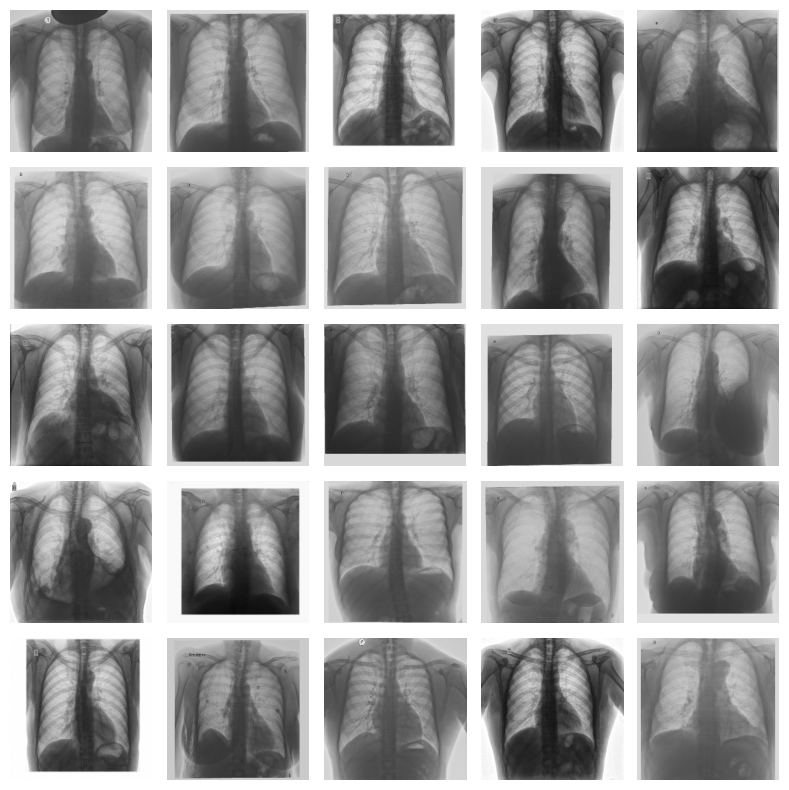

In [8]:
input, targets = next(iter(train_loader))

print(f"Velikost učne množice:   {len(train_dataset)}")
print(f"Velikost validacijske množice:   {len(val_dataset)}")
print(f"Velikost testne množice:   {len(test_dataset)}")
print(f"Dimenzija slik: {input[0].numpy().shape}")

#string_decoded = label_encoder.inverse_transform(targets.ravel())
#print(string_decoded)

dim = int(len(input) ** 0.5)

_, axes = plt.subplots(dim, dim, figsize=(8, 8), squeeze=False)
for i in range(dim):
    for j in range(dim):
        axes[i, j].imshow(input[dim * i + j].numpy().transpose((1,2,0)), cmap="gray")
        #axes[i, j].set_title(string_decoded[dim * i + j], fontsize=10)
        axes[i, j].axis("off")
            
plt.tight_layout()

In [9]:
#"IMAGENET1K_V1"
#model = LeNet300(3 * IMAGE_SIZE[0] * IMAGE_SIZE[1], NUM_CHANNELS)

#model = Conv6(NUM_CHANNELS)

#model = densenet121(weights=None)
#num_ftrs = model.classifier.in_features
#model.classifier = torch.nn.Linear(num_ftrs, NUM_CHANNELS)

#model = resnet18(weights=None)
#num_ftrs = model.fc.in_features
#model.fc = torch.nn.Linear(num_ftrs, NUM_CHANNELS)

#model = alexnet(weights=None)
#num_ftrs = model.classifier[6].in_features
#model.classifier[6] = torch.nn.Linear(num_ftrs, NUM_CHANNELS)

model = vgg11(weights=None)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = torch.nn.Linear(num_ftrs, NUM_CHANNELS)

#model = efficientnet_v2_s(weights=None)
#num_ftrs = model.classifier[1].in_features
#model.classifier[1] = torch.nn.Linear(num_ftrs, NUM_CHANNELS)ž

#model = shufflenet_v2_x1_0(weights=None)
#num_ftrs = model.fc.in_features
#model.fc = torch.nn.Linear(num_ftrs, NUM_CHANNELS)

#loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = torch.nn.MSELoss()

## KANALI SO NA RGB
print(torchinfo.summary(model, (BATCH_SIZE, 3, IMAGE_SIZE[0], IMAGE_SIZE[1])))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [32, 1]                   --
├─Sequential: 1-1                        [32, 512, 8, 8]           --
│    └─Conv2d: 2-1                       [32, 64, 256, 256]        1,792
│    └─ReLU: 2-2                         [32, 64, 256, 256]        --
│    └─MaxPool2d: 2-3                    [32, 64, 128, 128]        --
│    └─Conv2d: 2-4                       [32, 128, 128, 128]       73,856
│    └─ReLU: 2-5                         [32, 128, 128, 128]       --
│    └─MaxPool2d: 2-6                    [32, 128, 64, 64]         --
│    └─Conv2d: 2-7                       [32, 256, 64, 64]         295,168
│    └─ReLU: 2-8                         [32, 256, 64, 64]         --
│    └─Conv2d: 2-9                       [32, 256, 64, 64]         590,080
│    └─ReLU: 2-10                        [32, 256, 64, 64]         --
│    └─MaxPool2d: 2-11                   [32, 256, 32, 32]         -

In [5]:
sums = []
vsota = 0
for name, param in model.named_parameters():
    if 'weight' in name:
        print(name)
        print(np.prod(np.shape(param.data)))
        if np.prod(np.shape(param.data)) < 1000:
            vsota += np.prod(np.shape(param.data))
        sums += [np.prod(np.shape(param.data))]

sums = sorted(sums)
print(sums)
print(vsota)


NameError: name 'model' is not defined

In [10]:
ip = IterativePruning(model, apply_weights = True)

ip.start(loss_fn, train_loader, val_loader, test_loader, LR, NUM_EPOCHS, NUM_PRUNE_ITER, PRUNE_PER, patience = 3)

 ===| Prune iteration 1/10 |=== 
Name                            Freezed   Active    Total   Active(%)
total                                 0 128759488 128759488     100.00%


Epoch: 20, loss: 73.8803, val_loss: 111.9203 Validating: : 51it [00:05,  9.44it/s]                        
Testing: 51it [00:05, 10.08it/s]                        


MAE: 7.5917
 ===| Prune iteration 2/10 |=== 
Name                            Freezed   Active    Total   Active(%)
total                          38627849 90131639 128759488      70.00%


Epoch: 1, loss: 429.5845, val_loss: 374.7576 Training:   9%|▉         | 22/234 [00:11<01:45,  2.01it/s]

In [9]:
model = torch.load("./models/ResNet_20240910161143/model_20_a6_6_p1_48.pt")

model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        predictions.extend(outputs.squeeze().tolist())
        true_labels.extend(labels.tolist())

# Convert lists to numpy arrays for comparison
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Comparing the predict value with the correct value
selected_test_index = 2
print(f'Model predict: {predictions[:10]}')
print(f'Correct value: {true_labels[:10]}')

Model predict: [44.03858566 63.94981384 54.7803421  86.06906128 71.90965271 81.8812561
 28.70834732 79.34391785 85.24917603 28.00865364]
Correct value: [[24.]
 [63.]
 [56.]
 [78.]
 [73.]
 [78.]
 [33.]
 [73.]
 [84.]
 [33.]]
